# Frozen CLIP (my attempt, wrong)

In [35]:
from torchvision.models import vit_b_16
import torchvision.transforms as T
from torch import nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import ViT_B_16_Weights

In [32]:
model = vit_b_16(pretrained=True)
model.eval()
print()

c:\Users\giuse\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\giuse\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
dog_pic_path = r"C:\01_Learning\01_Data_science\01_University\01_UniTrento\01_Classes\Semester\3\Advanced_CV\Code\dog_pic.jpg"
dog_pic = PIL.Image.open(dog_pic_path)

In [34]:
preprocessing = ViT_B_16_Weights.DEFAULT.transforms()
dog_data = preprocessing(dog_pic).unsqueeze(0)

## Get feature maps

Note: the first three cells can be replaced by model._process_input(dog_data) -> [1, 196, 768]

In [35]:
conv_proj = model.conv_proj(dog_data) 
conv_proj.shape # (224 - 16)/16 + 1 

torch.Size([1, 768, 14, 14])

In [36]:
p = model.patch_size
n = dog_data.shape[0]
n_h = dog_data.shape[2] // p
n_w = dog_data.shape[3] // p
print(f"patch_size: {p} \n height: {n_h} \n width: {n_w}")

patch_size: 16 
 height: 14 
 width: 14


In [37]:
# Permute needed because the self attention layer expects inputs in the format (N, S, E)
# S: sequence length (number of patches)
# E: embedding dimension
flattened_conv_proj = conv_proj.view(1, model.hidden_dim, n_h * n_w).permute(0, 2, 1)
flattened_conv_proj.shape

torch.Size([1, 196, 768])

In [38]:
batch_class_token = model.class_token.expand(n, -1, -1)
flattened_conv_proj_with_cls = torch.cat([batch_class_token, flattened_conv_proj], dim=1)
flattened_conv_proj_with_cls.shape

torch.Size([1, 197, 768])

In [51]:
output_enc_0[:,1:].mean(dim=1).shape

torch.Size([1, 768])

feature maps: torch.Size([14, 14, 768])


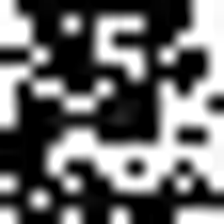

In [45]:
output_enc_0 = model.encoder.layers.encoder_layer_0(flattened_conv_proj_with_cls)
feature_maps_enc_0 = output_enc_0[0, 1:, :].view(n_h, n_w, model.hidden_dim) # remove the class token and reshape to 14x14
print("feature maps:",feature_maps_enc_0.shape)
patch = T.ToPILImage()(feature_maps_enc_0[:,:,0])
patch.resize((224, 224)) 

In [378]:
output_enc_1 = model.encoder.layers.encoder_layer_1(flattened_conv_proj_with_cls)
feature_maps_enc_1 = output_enc_1[0, 1:, :].view(n_h, n_w, model.hidden_dim) # remove the class token and reshape to 14x14
feature_maps_enc_1.shape

torch.Size([14, 14, 768])

[stack overflow post](https://stackoverflow.com/questions/75874965/how-do-i-extract-features-from-a-torchvision-visitiontransfomer-vit) says that it's not correct and I should only select the cls token

In [379]:
feature_cls_token = output_enc_0[:,-1,:]
feature_cls_token.shape

torch.Size([1, 768])

## Get affinity map

In [380]:
MLP = nn.Sequential(
    nn.Linear(model.hidden_dim, 256),
    nn.ReLU(),
    nn.Linear(256, model.hidden_dim)
)
output_MLP_0 = MLP(output_enc_0[0, 1:, :]).view(n_h, n_w, model.hidden_dim)
output_MLO_1 = MLP(output_enc_1[0,1:,:]).view(n_h, n_w, model.hidden_dim)
output_MLP_concat = torch.cat([output_MLP_0, output_MLO_1], dim=2)
output_MLP_concat.shape

torch.Size([14, 14, 1536])

In [381]:
conv_F_u = nn.Conv2d(output_MLP_concat.shape[2], model.hidden_dim, kernel_size=1)
F_u = conv_F_u(output_MLP_concat.permute(2, 0, 1))
F_u.shape

torch.Size([768, 14, 14])

In [382]:
flattened_F_u = F_u.view(model.hidden_dim, n_h * n_w)
A_f = flattened_F_u.T @ flattened_F_u
A_f.shape

torch.Size([196, 196])

-----

# WeCLIP

In [1]:
from WeCLIP.clip.clip import load # works pretty much like original CLIP implementation, but returns multi-level features and attention maps
from WeCLIP.WeCLIP_model.model_attn_aff_coco import WeCLIP


import torch.nn.functional as F
from torch import nn
import torch

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

c:\Users\giuse\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## get feature maps and weights

In [2]:
def encode_image(self, image, H, W, require_all_fts=False):
        f_x, f_attn = self.visual(image.type(self.dtype), H, W, require_all_fts=require_all_fts)
        # f = self.visual(image.type(self.dtype), H, W, require_all_fts=require_all_fts)
        return f_x, f_attn

def upsample_pos_emb(emb, new_size):
    # upsample the pretrained embedding for higher resolution
    # emb size NxD
    first = emb[:1, :]
    emb = emb[1:, :]
    N, D = emb.size(0), emb.size(1)
    size = int(np.sqrt(N))
    assert size * size == N
    #new_size = size * self.upsample
    emb = emb.permute(1, 0)
    emb = emb.view(1, D, size, size).contiguous()
    emb = F.upsample(emb, size=new_size, mode='bilinear',)
    emb = emb.view(D, -1).contiguous()
    emb = emb.permute(1, 0)
    emb = torch.cat([first, emb], 0)
    emb = nn.parameter.Parameter(emb.half())
    return emb

def generate_clip_fts(image, model, require_all_fts=True):
    model = model.cuda()

    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    h, w = image.shape[-2], image.shape[-1]
    image = image.cuda()
    
    image_features_all, attn_weight_list = model.encode_image(image, h, w, require_all_fts=require_all_fts)
        
    return image_features_all, attn_weight_list

In [3]:
vit_b_16_clip_pretrained = 'ViT-B/16'
encoder, preprocess = load(vit_b_16_clip_pretrained, device="cuda")

In [8]:
dog_pic_path = r"C:\01_Learning\01_Data_science\01_University\01_UniTrento\01_Classes\Semester\3\Advanced_CV\Code\dog_pic.jpg"
dog_pic = preprocess(Image.open(dog_pic_path)).unsqueeze(0).to("cuda")

b, c, h, w = dog_pic.shape
new_size = (h//16,w//16)

In [9]:
positional_embedding_new = upsample_pos_emb(encoder.visual.positional_embedding, new_size)
positional_embedding_new.shape

c:\Users\giuse\anaconda3\Lib\site-packages\torch\nn\functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([197, 768])

In [10]:
x = encoder.visual.conv1(dog_pic.type(encoder.dtype)) # patchify
x.shape

torch.Size([1, 768, 14, 14])

In [11]:
x = x.reshape(x.shape[0], x.shape[1], -1)
x = x.permute(0, 2, 1)
x.shape # flatten the patches and permute to (N, Patches, Embedding_dim) 

torch.Size([1, 196, 768])

In [12]:
# equivalent to (append cls token):
# x = torch.cat([encoder.visual.class_embedding.expand(x.shape[0], 1, -1), x], dim=1).dtype(x.dtype), but don't know if lose info this way
x = torch.cat([encoder.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1) 
x.shape

torch.Size([1, 197, 768])

In [13]:
x = x + positional_embedding_new # in the original implementation encoder.visual.positional_embedding_new
x = encoder.visual.ln_pre(x) # layer norm
x.shape

torch.Size([1, 197, 768])

In [14]:
x = x.permute(1,0,2) # needed to pass to encoder.visual.transformer
x.shape

torch.Size([197, 1, 768])

encoder.visual.transformer.resblocks.forward
```
attn_output, attn_weight = self.attention(self.ln_1(x))#(L,N,E)  (N,L,L)
        x = x + attn_output
        x = x + self.mlp(self.ln_2(x)) # linear 768 -> 3072, QuickGELU(), 3072 -> 768
        return x, attn_weight
```
self.attention() (since VisualTransformer self.attn_mask is None):
```
def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None 
        return self.attn(x, x, x, need_weights=True, attn_mask=self.attn_mask)
```

In [15]:
# forward encoder.visual.transformer
# x_all, attn_weights = encoder.visual(dog_pic.type(encoder.dtype), dog_pic.shape[-2], dog_pic.shape[-1], require_all_fts=False)
attn_weights = []
x_all = []
layers = encoder.visual.transformer.layers if x.shape[0] == 77 else encoder.visual.transformer.layers-1
for i in range(layers):
    x, attn_weight = encoder.visual.transformer.resblocks[i](x) # 
    x_all.append(x)
    attn_weights.append(attn_weight)

In [16]:
# all the previous steps are equivalent to:
image_features_all, attn_weight_list = generate_clip_fts(dog_pic, encoder, require_all_fts=True)

In [17]:
# length of list = num of residual attention blocks - 1 (not understood why), but still one for each block
# multihead attention + layer norm + MLP + layer norm
print(attn_weight_list[0].shape, image_features_all[0].shape, len(image_features_all), len(attn_weight_list))

torch.Size([1, 197, 197]) torch.Size([197, 1, 768]) 11 11


## get CAM and fusing decoder

In [18]:
cam_list = []

In [19]:
fts_all_stack = torch.stack(image_features_all,dim=0)
fts_all_stack.shape

torch.Size([11, 197, 1, 768])

In [20]:
attn_weight_stack = torch.stack(attn_weight_list, dim=0).permute(1, 0, 2, 3)
attn_weight_stack.shape

torch.Size([1, 11, 197, 197])

In [21]:
require_all_fts = True

In [22]:
if require_all_fts == True:
    # take always only the last layer for cam
    cam_fts_all = fts_all_stack[-1].unsqueeze(0).permute(2, 1, 0, 3)  # (1, hw, 1, c)
else:
    cam_fts_all = fts_all_stack.permute(2, 1, 0, 3)
cam_fts_all.shape

torch.Size([1, 197, 1, 768])

In [23]:
all_img_tokens = fts_all_stack[:, 1:, ...] # remove the class token
all_img_tokens.shape

torch.Size([11, 196, 1, 768])

In [24]:
img_tokens_channel = all_img_tokens.size(-1)
img_tokens_channel # get embedding dimension

768

In [25]:
all_img_tokens = all_img_tokens.permute(0, 2, 3, 1)
all_img_tokens.shape

torch.Size([11, 1, 768, 196])

In [26]:
all_img_tokens = all_img_tokens.reshape(-1, b, img_tokens_channel, h // 16, w // 16)
all_img_tokens.shape # get back patches

torch.Size([11, 1, 768, 14, 14])

### fusion step of image features

In [27]:
class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.proj_2 = nn.Linear(embed_dim, embed_dim)
        # self.proj_3 = nn.Linear(embed_dim*2, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        x = F.relu(x)
        x = self.proj_2(x)
        return x

In [28]:
class SegFormerHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, in_channels=128, embedding_dim=256, num_classes=20, index=11, **kwargs):
        super(SegFormerHead, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.indexes = index #6 #11

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = self.in_channels

        linear_layers = [MLP(input_dim=c1_in_channels, embed_dim=embedding_dim) for i in range(self.indexes)]
        self.linears_modulelist = nn.ModuleList(linear_layers)

        self.linear_fuse = nn.Conv2d(embedding_dim*self.indexes, embedding_dim, kernel_size=1)
        self.dropout = nn.Dropout2d(0.1)


    def forward(self, x_all):
        x_list = []
        for ind in range(x_all.shape[0]):
            x = x_all[ind,:, :, :, :]
            n, _, h, w = x.shape
            _x = self.linears_modulelist[ind](x.float()).permute(0,2,1).reshape(n, -1, x.shape[2], x.shape[3])
            x_list.append(_x)
        x_list = torch.cat(x_list, dim=1)
        x = self.linear_fuse(x_list)
        x = self.dropout(x)

        return x

In [29]:
all_img_tokens_emb_dim = all_img_tokens.shape[2]
num_feature_maps = all_img_tokens.shape[0]
output_embedding_dim = 256

In [96]:
linear_layers = [MLP(input_dim=all_img_tokens_emb_dim, embed_dim=output_embedding_dim) for i in range(num_feature_maps)]
linears_modulelist = nn.ModuleList(linear_layers).to("cuda")
linears_modulelist

ModuleList(
  (0-10): 11 x MLP(
    (proj): Linear(in_features=768, out_features=256, bias=True)
    (proj_2): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [97]:
# merge the output of the MLPs
linear_fuse = nn.Conv2d(output_embedding_dim*num_feature_maps, output_embedding_dim, kernel_size=1).to("cuda")
linear_fuse

Conv2d(2816, 256, kernel_size=(1, 1), stride=(1, 1))

In [101]:
all_img_tokens[0,...].shape

torch.Size([1, 768, 14, 14])

In [105]:
# performed internally by MLP forward
all_img_tokens[0,...].float().flatten(2).transpose(1,2).shape

torch.Size([1, 196, 768])

In [102]:
# This operation is performed independently for each of the 196 vectors in the sequence
linears_modulelist[0](all_img_tokens[0,...].float()).shape

torch.Size([1, 196, 256])

In [109]:
x_list = []
for ind in range(all_img_tokens.shape[0]):
    x = all_img_tokens[ind,:, :, :, :]
    n, _, h, w = x.shape
    _x = linears_modulelist[ind](x.float()).permute(0,2,1).reshape(n, -1, x.shape[2], x.shape[3])
    x_list.append(_x)
x_list = torch.cat(x_list, dim=1)
x_list.shape

torch.Size([1, 2816, 14, 14])

In [113]:
fused_x = linear_fuse(x_list)
fused_x.shape

torch.Size([1, 256, 14, 14])

previous steps equivalent to the following:

In [114]:
# equivalentl to:
all_img_tokens_emb_dim = all_img_tokens.shape[2]
num_feature_maps = all_img_tokens.shape[0]
decorder_fts_fuse = SegFormerHead(in_channels=[all_img_tokens_emb_dim, all_img_tokens_emb_dim, all_img_tokens_emb_dim, all_img_tokens_emb_dim],
                                  embedding_dim=output_embedding_dim, # output embedding dimension 
                                  num_classes=20, # doesn't have any influence on the output here
                                  index=num_feature_maps).to("cuda")
# fuse the features from the encoder
fts = decorder_fts_fuse(all_img_tokens)
fts.shape

torch.Size([1, 256, 14, 14])

In [116]:
attn_fts = fts.clone()
_, _, fts_h, fts_w = fts.shape

### CAM computation